In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, PredictionErrorDisplay, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, RandomizedSearchCV, GridSearchCV
import xgboost as xg
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Reading the csv file 

In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Existing of empty rows

In [4]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### The number of unique elements of each row

In [5]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

### Label Encoding of string values

In [6]:
label_encoder = LabelEncoder() 
  
df['region']= label_encoder.fit_transform(df['region'])
df['sex']= label_encoder.fit_transform(df['sex'])
df['smoker']= label_encoder.fit_transform(df['smoker'])
df['charges'] = round(df['charges'],0)

In [7]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16885.0
1,18,1,33.770,1,0,2,1726.0
2,28,1,33.000,3,0,2,4449.0
3,33,1,22.705,0,0,1,21984.0
4,32,1,28.880,0,0,1,3867.0
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,1,10601.0
1334,18,0,31.920,0,0,0,2206.0
1335,18,0,36.850,0,0,2,1630.0
1336,21,0,25.800,0,0,3,2008.0


### Which elements we do not need? --- Correlation Matrix 

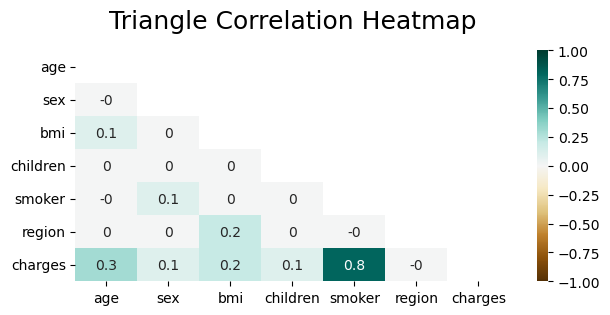

In [8]:
plt.figure(figsize=(7, 3))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(round(df.corr(),1), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [9]:
df = df.drop(['region'], axis = 1)

In [10]:
df

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16885.0
1,18,1,33.770,1,0,1726.0
2,28,1,33.000,3,0,4449.0
3,33,1,22.705,0,0,21984.0
4,32,1,28.880,0,0,3867.0
...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10601.0
1334,18,0,31.920,0,0,2206.0
1335,18,0,36.850,0,0,1630.0
1336,21,0,25.800,0,0,2008.0


### Dividing data on the test and train splits

In [11]:
y = df['charges']
X = df.drop(['charges'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling the data 

In [12]:
sc = RobustScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## XG_boost 

In [13]:
xgb_r = xg.XGBRegressor()

In [14]:
xg_params_rand = {
    'booster': ['gbtree'],
    'min_child_weight': [1, 10, 20, 30, 40, 50, 100],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5],
    'n_estimators': [10, 20, 30, 40, 50]
}

### Using Optimization methods (RandomizedSearch) to achieve best performance of model

In [15]:
xg_rand = RandomizedSearchCV(estimator=xgb_r,
                       param_distributions=xg_params_rand,
                       cv=10,
                       n_jobs=-1,
                       return_train_score=True)

### The proccess of fitting the model and getting predicted values

In [16]:
import time
start_time = time.time()
xg_rand_fit = xg_rand.fit(X_train_scaled, y_train) 
  
y_pred = xg_rand.predict(X_test_scaled) 

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 8.41162657737732 seconds


### Using K-Fold Cross Validation to get accurracy of model and preserve overfitting

In [17]:
k_folds = KFold(n_splits = 10)

scores_xgb = cross_val_score(xg_rand, X_train_scaled, y_train, cv = k_folds)

In [18]:
print("Cross Validation Scores: ", scores_xgb)
print("Average CV Score: ", scores_xgb.mean())
print("Number of CV Scores used in Average: ", len(scores_xgb))

Cross Validation Scores:  [0.85338376 0.82328828 0.91856789 0.9108411  0.85422417 0.7771212
 0.77628985 0.80708372 0.85345714 0.86466639]
Average CV Score:  0.8438923499672398
Number of CV Scores used in Average:  10


In [19]:
test_score = xg_rand.score(X_test_scaled, y_test)
print(f'Test set score: {test_score}')

Test set score: 0.8690344529136705


In [20]:
mape = mean_absolute_percentage_error(y[0:268], y_pred)
print(f'Mape set score: {mape}')

Mape set score: 1.6398986386085304


### Results of optimization and tuning 

In [21]:
cv_results_xg_rand = pd.DataFrame.from_dict(xg_rand_fit.cv_results_)

In [22]:
xg_top_rank = cv_results_xg_rand[cv_results_xg_rand['rank_test_score'] == 1]

In [23]:
print('XGBoost Regressor')
print(xg_top_rank['mean_test_score'])
print(xg_top_rank['mean_train_score'])

# Print the best parameters of the Random Forest Classifier
print('\n The best Parameters are : ')
print(xg_rand_fit.best_params_)

XGBoost Regressor
7    0.843037
Name: mean_test_score, dtype: float64
7    0.882884
Name: mean_train_score, dtype: float64

 The best Parameters are : 
{'n_estimators': 10, 'min_child_weight': 40, 'max_depth': 5, 'learning_rate': 0.5, 'booster': 'gbtree'}


### Calculation of various metrics for regression tasks 

In [24]:
mae = mean_absolute_error(y_test, y_pred[0:268])
mse = mean_squared_error(y_test, y_pred[0:268])
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred[0:268])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 2627.839777021266
Mean Squared Error: 20332168.281059273
Root Mean Squared Error: 4509.120566258932
R-squared: 0.8690344529136705


### A plot to check the interpolation of line to predicted values

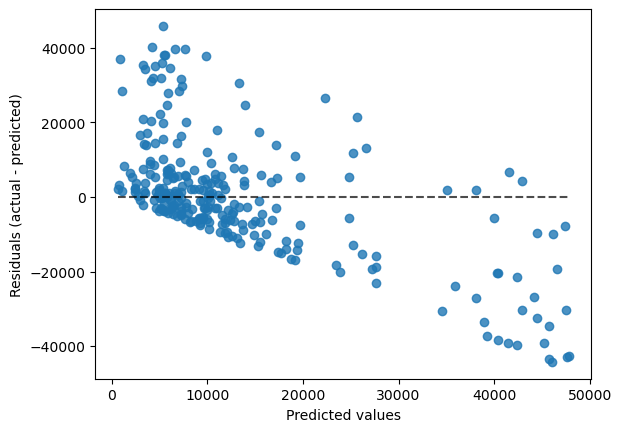

In [25]:
display = PredictionErrorDisplay(y_true=y[0:268], y_pred=y_pred)
display.plot()
plt.show()

## CatBoost

In [26]:
cat_features = ['age', 'sex', 'bmi', 'children', 'smoker']

In [27]:
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, return_train_score=True)
grid_fit = grid.fit(X_train_scaled, y_train)

0:	learn: 11563.4727782	total: 148ms	remaining: 14.6s
1:	learn: 11136.5278463	total: 154ms	remaining: 7.53s
2:	learn: 10734.8852421	total: 159ms	remaining: 5.16s
3:	learn: 10343.7946175	total: 164ms	remaining: 3.93s
4:	learn: 10010.9088657	total: 167ms	remaining: 3.18s
5:	learn: 9687.1898209	total: 171ms	remaining: 2.67s
6:	learn: 9379.8655460	total: 174ms	remaining: 2.31s
7:	learn: 9084.7046308	total: 177ms	remaining: 2.03s
8:	learn: 8790.4006651	total: 180ms	remaining: 1.82s
9:	learn: 8547.4947050	total: 181ms	remaining: 1.63s
10:	learn: 8275.5322528	total: 184ms	remaining: 1.49s
11:	learn: 8026.8211121	total: 187ms	remaining: 1.37s
12:	learn: 7804.8038476	total: 189ms	remaining: 1.27s
13:	learn: 7576.2589287	total: 192ms	remaining: 1.18s
14:	learn: 7360.7509634	total: 194ms	remaining: 1.1s
15:	learn: 7186.1386243	total: 196ms	remaining: 1.03s
16:	learn: 6997.3912468	total: 198ms	remaining: 968ms
17:	learn: 6849.2357031	total: 201ms	remaining: 914ms
18:	learn: 6686.5787784	total: 203

In [28]:
y_pred_cat = grid.predict(X_test_scaled) 

In [29]:
k_folds = KFold(n_splits = 10)

scores_cat = cross_val_score(grid, X_train_scaled, y_train, cv = k_folds)

0:	learn: 11590.2481391	total: 3.25ms	remaining: 321ms
1:	learn: 11166.3656094	total: 6.56ms	remaining: 321ms
2:	learn: 10788.7866855	total: 9.54ms	remaining: 309ms
3:	learn: 10411.3504267	total: 11.7ms	remaining: 280ms
4:	learn: 10079.1312150	total: 14.4ms	remaining: 273ms
5:	learn: 9755.8979334	total: 17.1ms	remaining: 269ms
6:	learn: 9451.3366429	total: 19.9ms	remaining: 264ms
7:	learn: 9153.5192633	total: 22.6ms	remaining: 260ms
8:	learn: 8876.2321175	total: 25.5ms	remaining: 258ms
9:	learn: 8596.7615532	total: 27.7ms	remaining: 250ms
10:	learn: 8316.6909725	total: 29.4ms	remaining: 238ms
11:	learn: 8066.9138945	total: 32.4ms	remaining: 237ms
12:	learn: 7848.4612233	total: 35.5ms	remaining: 238ms
13:	learn: 7633.6983908	total: 38.4ms	remaining: 236ms
14:	learn: 7412.7875230	total: 40ms	remaining: 227ms
15:	learn: 7222.7962025	total: 42.8ms	remaining: 225ms
16:	learn: 7024.6655460	total: 45.7ms	remaining: 223ms
17:	learn: 6852.0323561	total: 48.6ms	remaining: 221ms
18:	learn: 6698.8

69:	learn: 4301.8290733	total: 181ms	remaining: 77.6ms
70:	learn: 4297.6928908	total: 184ms	remaining: 75.3ms
71:	learn: 4291.1110715	total: 188ms	remaining: 72.9ms
72:	learn: 4287.7295585	total: 189ms	remaining: 69.8ms
73:	learn: 4278.6822108	total: 192ms	remaining: 67.4ms
74:	learn: 4272.7017207	total: 195ms	remaining: 65ms
75:	learn: 4267.5823926	total: 198ms	remaining: 62.7ms
76:	learn: 4257.7796875	total: 202ms	remaining: 60.5ms
77:	learn: 4250.6005649	total: 206ms	remaining: 58.2ms
78:	learn: 4245.7333572	total: 210ms	remaining: 55.7ms
79:	learn: 4238.7980382	total: 213ms	remaining: 53.1ms
80:	learn: 4233.4699107	total: 215ms	remaining: 50.5ms
81:	learn: 4230.3753898	total: 218ms	remaining: 47.9ms
82:	learn: 4225.4624771	total: 222ms	remaining: 45.4ms
83:	learn: 4220.4847420	total: 225ms	remaining: 42.8ms
84:	learn: 4217.4917816	total: 226ms	remaining: 39.9ms
85:	learn: 4212.9751520	total: 229ms	remaining: 37.3ms
86:	learn: 4212.4022290	total: 231ms	remaining: 34.5ms
87:	learn: 4

30:	learn: 5416.3196948	total: 183ms	remaining: 406ms
31:	learn: 5346.1395611	total: 189ms	remaining: 402ms
32:	learn: 5282.9829687	total: 195ms	remaining: 395ms
33:	learn: 5218.9799521	total: 201ms	remaining: 391ms
34:	learn: 5180.7975496	total: 203ms	remaining: 378ms
35:	learn: 5129.9004190	total: 210ms	remaining: 373ms
36:	learn: 5076.5430313	total: 216ms	remaining: 368ms
37:	learn: 5028.2005490	total: 222ms	remaining: 363ms
38:	learn: 4985.7241719	total: 229ms	remaining: 358ms
39:	learn: 4940.7124807	total: 236ms	remaining: 354ms
40:	learn: 4916.9636869	total: 238ms	remaining: 343ms
41:	learn: 4887.4524129	total: 243ms	remaining: 335ms
42:	learn: 4853.7786960	total: 250ms	remaining: 331ms
43:	learn: 4827.3985009	total: 257ms	remaining: 328ms
44:	learn: 4796.1139984	total: 264ms	remaining: 322ms
45:	learn: 4771.1717399	total: 269ms	remaining: 315ms
46:	learn: 4752.1022232	total: 272ms	remaining: 306ms
47:	learn: 4731.4974957	total: 275ms	remaining: 298ms
48:	learn: 4706.4362090	tota

0:	learn: 11757.0397836	total: 2.83ms	remaining: 280ms
1:	learn: 11323.3116496	total: 5.59ms	remaining: 274ms
2:	learn: 10937.2084249	total: 8.09ms	remaining: 261ms
3:	learn: 10533.0346176	total: 9.88ms	remaining: 237ms
4:	learn: 10191.2536710	total: 12.3ms	remaining: 234ms
5:	learn: 9858.4271544	total: 14.8ms	remaining: 231ms
6:	learn: 9552.0201382	total: 17.2ms	remaining: 229ms
7:	learn: 9244.6899011	total: 19.9ms	remaining: 229ms
8:	learn: 8953.8421802	total: 22.3ms	remaining: 225ms
9:	learn: 8702.0473897	total: 23.6ms	remaining: 212ms
10:	learn: 8423.4395597	total: 25.2ms	remaining: 204ms
11:	learn: 8165.1335098	total: 27.8ms	remaining: 204ms
12:	learn: 7919.6823890	total: 30.5ms	remaining: 204ms
13:	learn: 7689.0538880	total: 33.1ms	remaining: 203ms
14:	learn: 7465.2099019	total: 34.6ms	remaining: 196ms
15:	learn: 7271.6001284	total: 37.1ms	remaining: 195ms
16:	learn: 7077.0825018	total: 39.6ms	remaining: 193ms
17:	learn: 6923.4175755	total: 41.9ms	remaining: 191ms
18:	learn: 6752

66:	learn: 4313.8140320	total: 381ms	remaining: 188ms
67:	learn: 4303.0849073	total: 389ms	remaining: 183ms
68:	learn: 4295.5319916	total: 395ms	remaining: 177ms
69:	learn: 4286.7421978	total: 402ms	remaining: 172ms
70:	learn: 4278.5065416	total: 409ms	remaining: 167ms
71:	learn: 4271.6811096	total: 415ms	remaining: 161ms
72:	learn: 4267.2351318	total: 421ms	remaining: 156ms
73:	learn: 4262.3990296	total: 428ms	remaining: 150ms
74:	learn: 4253.3996852	total: 436ms	remaining: 145ms
75:	learn: 4247.5124835	total: 443ms	remaining: 140ms
76:	learn: 4240.8458457	total: 450ms	remaining: 134ms
77:	learn: 4235.2276252	total: 456ms	remaining: 129ms
78:	learn: 4229.6947776	total: 463ms	remaining: 123ms
79:	learn: 4223.1294604	total: 468ms	remaining: 117ms
80:	learn: 4216.0928860	total: 474ms	remaining: 111ms
81:	learn: 4212.6817427	total: 480ms	remaining: 105ms
82:	learn: 4207.7893670	total: 485ms	remaining: 99.4ms
83:	learn: 4201.7395035	total: 491ms	remaining: 93.5ms
84:	learn: 4197.4690859	to

96:	learn: 4250.3962522	total: 187ms	remaining: 5.8ms
97:	learn: 4242.7676362	total: 190ms	remaining: 3.88ms
98:	learn: 4237.6259761	total: 193ms	remaining: 1.95ms
99:	learn: 4233.3297040	total: 196ms	remaining: 0us
0:	learn: 11566.8279650	total: 2.69ms	remaining: 266ms
1:	learn: 11173.5360509	total: 5.48ms	remaining: 268ms
2:	learn: 10785.3892955	total: 7.74ms	remaining: 250ms
3:	learn: 10394.1732534	total: 9.48ms	remaining: 227ms
4:	learn: 10085.9656655	total: 11.9ms	remaining: 225ms
5:	learn: 9763.2344564	total: 14.2ms	remaining: 222ms
6:	learn: 9460.0413258	total: 16.4ms	remaining: 218ms
7:	learn: 9164.5356169	total: 18.7ms	remaining: 216ms
8:	learn: 8867.8631123	total: 21.2ms	remaining: 214ms
9:	learn: 8622.3801929	total: 22.5ms	remaining: 203ms
10:	learn: 8348.2331297	total: 24.3ms	remaining: 197ms
11:	learn: 8084.1737149	total: 26.7ms	remaining: 196ms
12:	learn: 7836.6109988	total: 29ms	remaining: 194ms
13:	learn: 7622.7305429	total: 31.4ms	remaining: 193ms
14:	learn: 7407.17983

In [30]:
print("Cross Validation Scores: ", scores_cat)
print("Average CV Score: ", scores_cat.mean())
print("Number of CV Scores used in Average: ", len(scores_cat))

Cross Validation Scores:  [0.85549191 0.82742656 0.92584912 0.90198667 0.85710121 0.78197205
 0.79215184 0.79577128 0.86217734 0.85584722]
Average CV Score:  0.8455775203736504
Number of CV Scores used in Average:  10


In [31]:
test_score = grid.score(X_test_scaled, y_test)
print(f'Test set score: {test_score}')

Test set score: 0.8792719428996058


In [32]:
mape = mean_absolute_percentage_error(y[0:268], y_pred_cat)
print(f'Mape set score: {mape}')

Mape set score: 1.591402164926483


In [33]:
mae = mean_absolute_error(y_test, y_pred_cat[0:268])
mse = mean_squared_error(y_test, y_pred_cat[0:268])
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_cat[0:268])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 2477.1699103292044
Mean Squared Error: 18742816.166701388
Root Mean Squared Error: 4329.2974218343315
R-squared: 0.8792719428996058


In [34]:
cv_results_cat = pd.DataFrame.from_dict(grid.cv_results_)

In [35]:
cat_top_rank = cv_results_cat[cv_results_cat['rank_test_score'] == 1]

In [36]:
print('CatBoost Regressor')
print(cat_top_rank['mean_test_score'])
print(cat_top_rank['mean_train_score'])

# Print the best parameters of the Random Forest Classifier
print('\n The best Parameters are : ')
print(grid.best_params_)

CatBoost Regressor
7    0.845241
Name: mean_test_score, dtype: float64
7    0.885044
Name: mean_train_score, dtype: float64

 The best Parameters are : 
{'depth': 6, 'iterations': 100, 'learning_rate': 0.05}


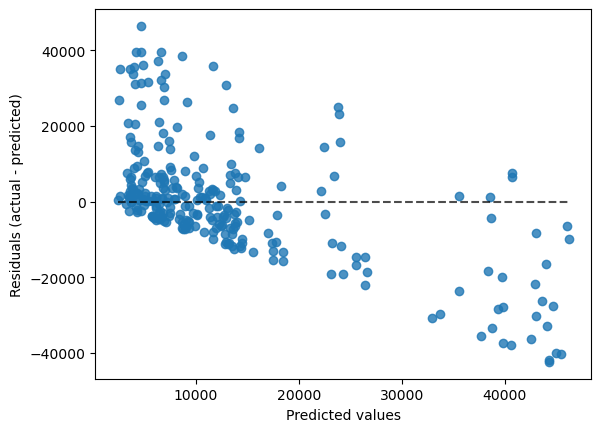

In [37]:
display = PredictionErrorDisplay(y_true=y[0:268], y_pred=y_pred_cat)
display.plot()
plt.show()

## I have chosen the Ensemble algorithms, because it works more logically than other simple algorithms such as linear regression.

## Ensemble algorithms expect to have the base learners which are uniformly bad at the remainder so that when all the predictions are combined, bad predictions cancels out and better one sums up to form final good predictions. 

## Therefore using Ensemble Learning better than using ML algorithms separately 

## DecisionTree 

In [38]:
model = DecisionTreeRegressor()

In [39]:
params = {
    'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],
    'splitter': ['best', 'random'],
    'min_samples_leaf': [3, 5, 7, 8, 10, 20, 30, 40, 50, 100],
    'min_samples_split': [3, 5, 7, 8, 10, 20, 30, 40, 50, 100],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'splitter':['best', 'random']
}

In [40]:
dt_rand = RandomizedSearchCV(estimator=model,
                       param_distributions=params,
                       cv=10,
                       n_jobs=-1,
                       return_train_score=True,
                       error_score='raise')

In [41]:
dt_rand_fit = dt_rand.fit(X_train_scaled, y_train) 
  
y_pred_dt = dt_rand.predict(X_test_scaled) 

In [42]:
mae = mean_absolute_error(y_test, y_pred_dt[0:268])
mse = mean_squared_error(y_test, y_pred_dt[0:268])
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_dt[0:268])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 2086.341417910448
Mean Squared Error: 21988945.73041045
Root Mean Squared Error: 4689.237222663239
R-squared: 0.8583626562781537


In [43]:
scores_dt = cross_val_score(dt_rand, X_train_scaled, y_train, cv = k_folds)

In [44]:
print("Cross Validation Scores: ", scores_dt)
print("Average CV Score: ", scores_dt.mean())
print("Number of CV Scores used in Average: ", len(scores_dt))

Cross Validation Scores:  [0.84819593 0.79786481 0.91521485 0.90036673 0.86205574 0.77698777
 0.76636364 0.80614549 0.85102182 0.83992643]
Average CV Score:  0.8364143226945799
Number of CV Scores used in Average:  10


In [45]:
cv_results_dt_rand = pd.DataFrame.from_dict(dt_rand_fit.cv_results_)

In [46]:
dt_top_rank = cv_results_dt_rand[cv_results_dt_rand['rank_test_score'] == 1]

In [47]:
print('Decision Tree Regressor')
print(dt_top_rank['mean_test_score'])
print(dt_top_rank['mean_train_score'])

# Print the best parameters of the Random Forest Classifier
print('\n The best Parameters are : ')
print(dt_rand_fit.best_params_)

Decision Tree Regressor
7    0.835681
Name: mean_test_score, dtype: float64
7    0.84795
Name: mean_train_score, dtype: float64

 The best Parameters are : 
{'splitter': 'best', 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 4, 'criterion': 'absolute_error'}


In [48]:
test_score = dt_rand.score(X_test_scaled, y_test)
print(f'Test set score: {test_score}')

Test set score: 0.8583626562781537


In [49]:
mape = mean_absolute_percentage_error(y[0:268], y_pred_dt)
print(f'Mape set score: {mape}')

Mape set score: 1.5310056691390623


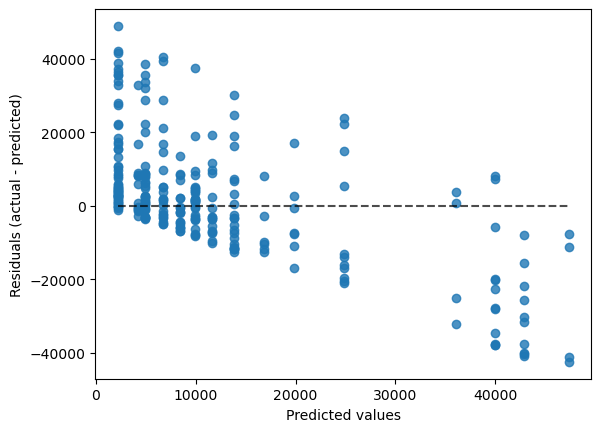

In [50]:
display = PredictionErrorDisplay(y_true=y[0:268], y_pred=y_pred_dt)
display.plot()
plt.show()

| Algorithm             | Test Score | Mape | Hyperparameters |
|-----------------------|:----------:|:----:| :----------------|
| XGBoost               | 87%        | 1.66 |'n_estimators': 50, 'min_child_weight': 30, 'max_depth': 4, 'learning_rate': 0.1, 'booster': 'gbtree' |
| CatBoost              | 87%        | 1.59 | 'depth': 6, 'iterations': 100, 'learning_rate': 0.05 |
| Decision Tree         | 85%        | 1.64 | 'splitter': 'best', 'min_samples_split': 30, 'min_samples_leaf': 40, 'max_depth': 10, 'criterion': 'poisson' |